**BrainSense Streaming modality:**
The aim is to visualize LFP recordings from PERCEPT patients and the stimulation as recorded by the Medtronic system. We need to see how much delay there is between reported stim and LFP visible artefact. Then, we need to align those datas with the EMG bipolar recordings to see if the artefacts are sufficiently precise to do a perfect alignement.

**Indefinite Streaming modality:**
The aim is to visualize LFP recordings from PERCEPT patients and look for artefacts caused by tapping on the IPG (10 taps in the beginning of each recordings). Then, we need to align those datas with the EMG bipolar recordings to see if the artefacts are sufficiently precise to do a perfect alignement.

Steps:
1) check if artefacts are always present in the LFP recordings
    --> artefacts present in 2/2 BS Streaming but with different amplitudes
    --> artefacts not found in Indefinite Streaming mode
2) check the delay between reported stim and visible artefact (for BrainSense Streaming only)
3) check if the artefacts are always present in EMG recordings --> for these, learn to open TMSi files
4) try to align based on first artefact from LFP recordings with EMG recording, then check if the other artefacts are automatically aligned.

**Careful** : because the sampling rate is different between the stim recorded (2Hz) and the LFP (250Hz), there is a delay between those signals when we try to align. Based on this experiment, it is important that we use the same sampling frequency between LFP recordings and EMG/accelerometers recordings I think..?


**Import all the librairies**

In [1]:
import os
import sys
import importlib
import json
from dataclasses import dataclass, field, fields
from itertools import compress
import csv
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import signal
import openpyxl
from openpyxl import Workbook, load_workbook
import xlrd
#MNE
import mne
from mne.time_frequency import tfr_morlet
from importlib import reload 

**Parameters to select the recording(s) of interest for the analysis**


In [ ]:
"""

incl_modalities: "survey", "streaming", "timeline", "indefiniteStreaming"
incl_session: "postop", "fu3m", "fu12m", "fu18m", "fu24m"
incl_condition: "m0s0", "m1s0", "m0s1", "m1s1"
incl_task: "rest", "tapping", "rota", "updrs", "monopolar"
incl_contact: "RingR", "SegmIntraR", "SegmInterR", "RingL", "SegmIntraL", "SegmInterL", "Bip02", "Bip13", "Ring", "Segments"

"""

Check package versions

In [2]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
#print('mne_bids', mne_bids.__version__)
print('mne', mne.__version__)


Python sys 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:14:58) [MSC v.1929 64 bit (AMD64)]
pandas 1.5.3
numpy 1.23.5
mne 1.3.0


Load PyPerceive functions

In [3]:
os.chdir('c:\\Users\\Juliette\\Research\\Projects\\Synchronization project\\Code\\Synchronization')
project_path = os.getcwd()
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.join(os.getcwd(), 'PyPerceive'))
os.chdir(os.path.join(os.getcwd(), 'code'))
code_path = os.getcwd()
print (f'working dir for analysis:{project_path}')
print (f'working dir to go fetch PyPerceive functions:{code_path}')

working dir for analysis:c:\Users\Juliette\Research\Projects\Synchronization project\Code\Synchronization
working dir to go fetch PyPerceive functions:c:\Users\Juliette\Research\Projects\Synchronization project\Code\PyPerceive\code


In [4]:
from PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class
)
import PerceiveImport.methods.load_rawfile as load_rawfile
import PerceiveImport.methods.find_folders as find_folders
import PerceiveImport.methods.metadata_helpers as metaHelpers

In [5]:
# reload classes during debugging
importlib.reload(main_class)
importlib.reload(session_class)
importlib.reload(task_class)
importlib.reload(condition_class)
importlib.reload(contact_class)
importlib.reload(metadata_class)
importlib.reload(modality_class)
importlib.reload(load_rawfile)
importlib.reload(find_folders)
importlib.reload(run_class)
importlib.reload(metaHelpers)

<module 'PerceiveImport.methods.metadata_helpers' from 'c:\\Users\\Juliette\\Research\\Projects\\Synchronization project\\Code\\PyPerceive\\code\\PerceiveImport\\methods\\metadata_helpers.py'>

In [6]:
#reset the proper working directory for the analysis
os.chdir(project_path)

In [24]:
# define an example instance and fill in the values of the dataclass PerceiveData 
# choose the values you are interested in analyzing further

sub061 = main_class.PerceiveData(
    sub = "061", 
    incl_modalities=['survey', 'streaming'],
    incl_session = ['postop', 'fu12m', 'fu18m'],
    incl_condition =['m0s0', ],
    incl_task = ["rest"],
    incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
    # use_bids=True,  # TODO: add to functionality
)

Creating RawArray with float64 data, n_channels=6, n_times=5312
    Range : 0 ... 5311 =      0.000 ...    21.244 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
inserted session (fu12m, survey) can not be found in the metadata table
inserted session (fu18m, survey) can not be found in the metadata table
Creating RawArray with float64 data, n_channels=6, n_times=31125
    Range : 0 ... 31124 =      0.000 ...   124.496 secs
Ready.
inserted session (fu12m, streaming) can not be found in the metadata table
inserted session (fu18m, streaming) can not be found in the metadata table


**MNE object** 
store the MNE object in a variable 

In [38]:
#store the MNE object in the variable
sub061_data = sub061.streaming.postop.m0s0.rest.run1.data
#look at the MNE object
sub061_data

<RawArray | 6 x 31125 (124.5 s), ~1.4 MB, data loaded>

**PLOT THE MNE OBJECT**

The data object has:
	31125 time samples,
	and a sample frequency of 250.0 Hz
	with a recording duration of 124.5 seconds.
	6 channels were labeled as 
['LFP_L_02_STN_MT', 'LFP_R_02_STN_MT', 'LFP_L_02_STN_MT_PEAK17Hz_THR20-30_AVG3000ms', 'LFP_R_02_STN_MT_PEAK17Hz_THR20-30_AVG3000ms', 'STIM_L_125Hz_60us', 'STIM_R_125Hz_60us'].


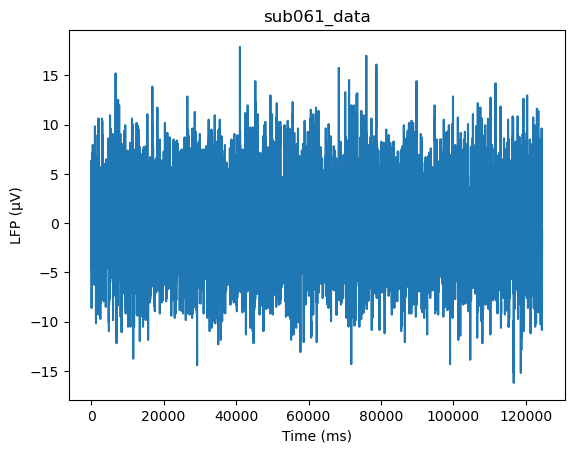

In [42]:
sub061_data.ch_names
n_chan = len(sub061_data.ch_names)
sub061_data.n_times #number of samples
sub061_data.times #timepoints set to zero
sub061_data._data # channel trials
sub061_data.info['sfreq'] # sampling frequency
time_duration = (sub061_data.n_times/sub061_data.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000
print(     
	f'The data object has:\n\t{sub061_data.n_times} time samples,'      
	f'\n\tand a sample frequency of {sub061_data.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{sub061_data.ch_names}.')
x_time=np.arange(0,time_duration_ms,time_duration_ms/sub061_data.n_times)
LFP_L_02_STN_MT = sub061_data.get_data()[0]
LFP_R_02_STN_MT =  sub061_data.get_data()[1]
plt.title('sub061_data')
plt.xlabel('Time (ms)')
plt.ylabel('LFP (µV)')
plt.plot(x_time,LFP_L_02_STN_MT)


**try with another subject**

In [ ]:
sub033 = main_class.PerceiveData(
    sub = "033", 
    incl_modalities=['survey', 'streaming'],
    incl_session = ['postop', 'fu12m', 'fu18m'],
    incl_condition =['m0s0','m1s0','m0s1','m1s1' ],
    incl_task = ["rest"],
    incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
    # use_bids=True,  # TODO: add to functionality
)

To plot BrainSense Streaming files:

In [ ]:
datapath = 'C:\\Users\\Juliette\\OneDrive - Charité - Universitätsmedizin Berlin\\Documents\\MATLAB\\RawFiles\\sub-033\\18MFU\\MedON\\sub-20210902PStn\\ses-2023020101261271\\ieeg'
filename = 'sub-20210902PStn_ses-2023020101261271_run-BrainSense20230201014600.mat'
data = mne.io.read_raw_fieldtrip(        
	os.path.join(datapath, filename),        
	info={}, # add info here        
	data_name='data',  # name of heading dict/ variable of original MATLAB object    
)
data.ch_names
n_chan = len(data.ch_names)
data.n_times #number of samples
data.times #timepoints set to zero
data._data # channel trials
data.info['sfreq'] # sampling frequency
time_duration = (data.n_times/data.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000
print(     
	f'The data object has:\n\t{data.n_times} time samples,'      
	f'\n\tand a sample frequency of {data.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{data.ch_names}.')
x_time=np.arange(0,time_duration_ms,4)
LFP_Stn_L_13 = data.get_data()[0]
LFP_Stn_R_13 =  data.get_data()[1]
plt.title('sub-033 18 MFU LFP STN L MedON 0.5mA stim L')
plt.xlabel('Time (ms)')
plt.ylabel('LFP (µV)')
plt.plot(x_time,LFP_Stn_L_13)


1) Check the presence of the artefacts in LFP recordings.
To plot BrainSense Streaming files with the stim:

Creating RawArray with float64 data, n_channels=6, n_times=43063
    Range : 0 ... 43062 =      0.000 ...   172.248 secs
Ready.


C:\Users\Juliette\AppData\Local\Temp\ipykernel_21356\2730155907.py:5: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = mne.io.read_raw_fieldtrip(
C:\Users\Juliette\AppData\Local\Temp\ipykernel_21356\2730155907.py:5: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_13. Making it a MISC channel.
  data = mne.io.read_raw_fieldtrip(
C:\Users\Juliette\AppData\Local\Temp\ipykernel_21356\2730155907.py:5: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_03. Making it a MISC channel.
  data = mne.io.read_raw_fieldtrip(
C:\Users\Juliette\AppData\Local\Temp\ipykernel_21356\2730155907.py:5: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_13_PEAK17Hz_THR20-30_AVG3000ms. Making it a MISC channel.
  data = mne.io.read_raw_fieldtrip(
C:\Users\Juliette\AppData\Local\Temp\ipykernel_21356\2730155907.py:5: RuntimeWarning: Cann

The data object has:
	43063 time samples,
	and a sample frequency of 250.0 Hz
	with a recording duration of 172.252 seconds.
	6 channels were labeled as 
['LFP_Stn_L_13', 'LFP_Stn_R_03', 'LFP_Stn_L_13_PEAK17Hz_THR20-30_AVG3000ms', 'LFP_Stn_R_03_PEAK16Hz_THR20-30_AVG3000ms', 'STIM_L_125Hz_60us', 'STIM_R_125Hz_60us'].


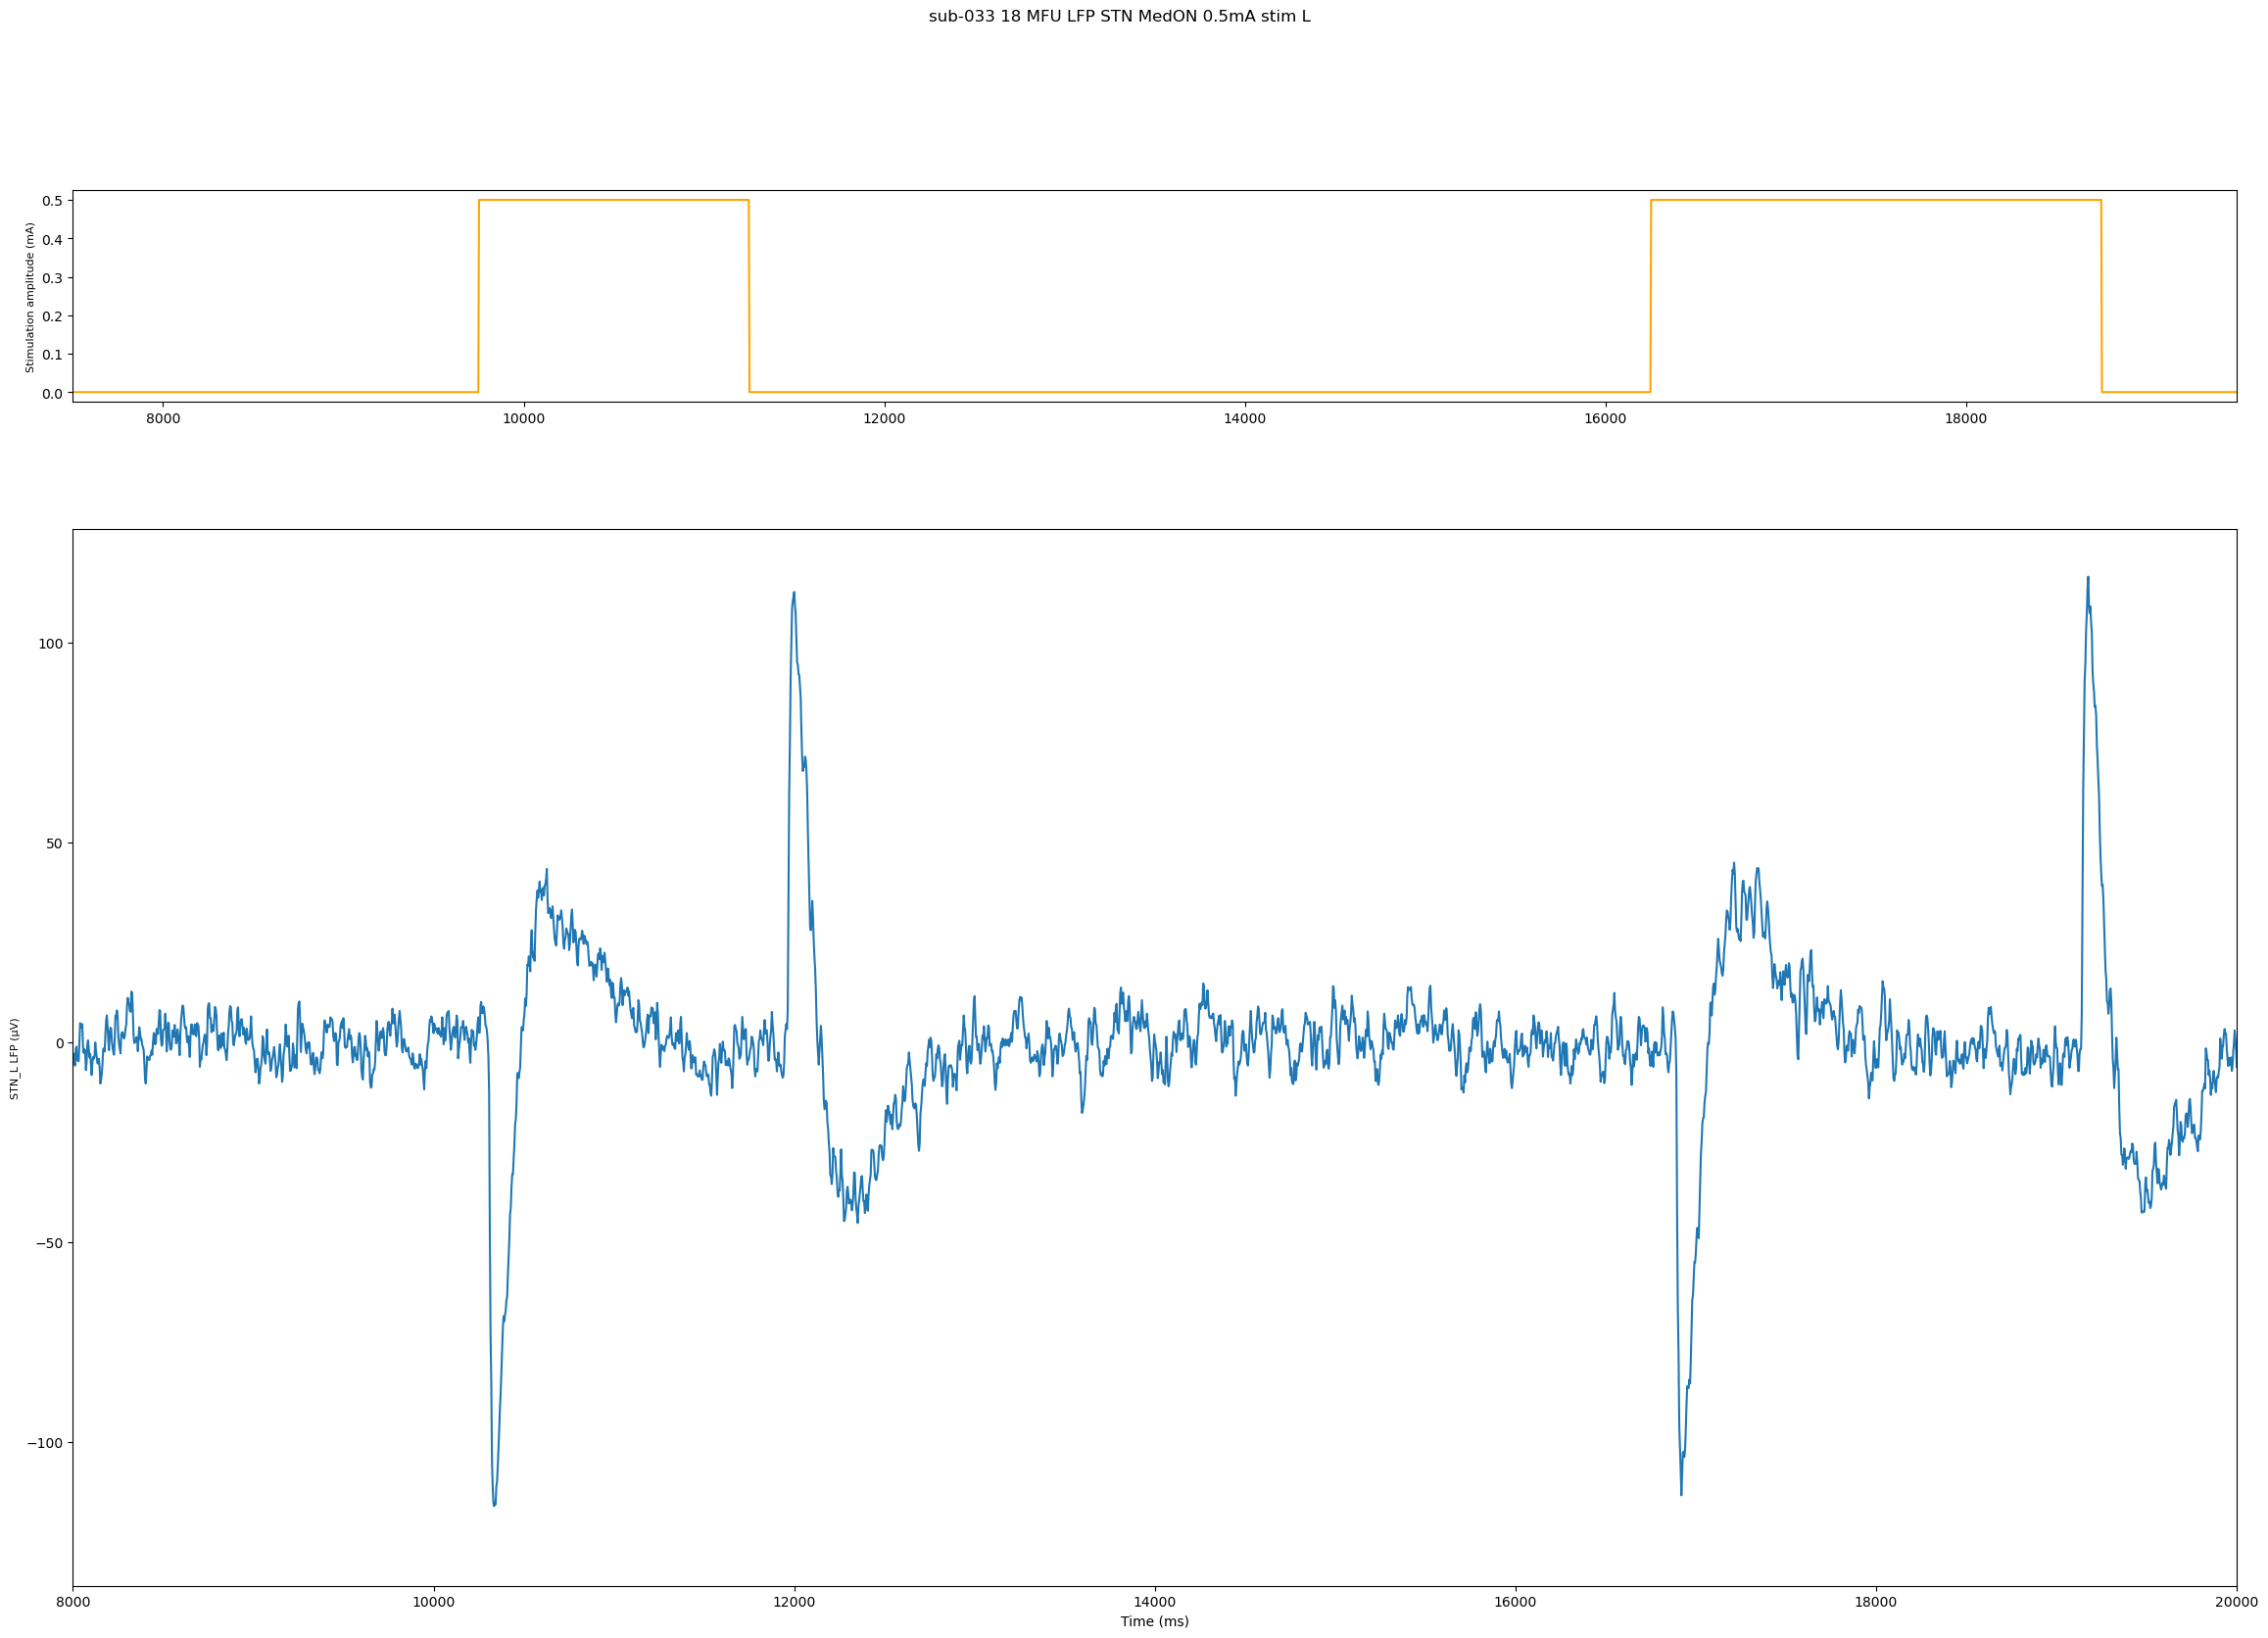

In [9]:
# First import the file and check the properties:

datapath = 'C:\\Users\\Juliette\\OneDrive\\Bureau\\Recordings\\PERCEPT recordings\\sub-029\\18MFU\\MedOFF\\sub-20210924PStn\\ses-2023020808345883\\ieeg'
filename = 'sub-20210924PStn_ses-2023020808345883_run-BrainSense20230208091500.mat'
data = mne.io.read_raw_fieldtrip(        
	os.path.join(datapath, filename),        
	info={}, # add info here        
	data_name='data',  # name of heading dict/ variable of original MATLAB object    
)
data.ch_names
n_chan = len(data.ch_names)
data.n_times #number of samples
data.times #timepoints set to zero
data._data # channel trials
data.info['sfreq'] # sampling frequency
time_duration = (data.n_times/data.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000
print(     
	f'The data object has:\n\t{data.n_times} time samples,'      
	f'\n\tand a sample frequency of {data.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{data.ch_names}.')
x_time=np.arange(0,time_duration_ms,4)

# fetch and plot the proper channels

LFP_Stn_L_13 = data.get_data()[0]
STIM_L_125Hz_60us =  data.get_data()[4]
fig, (ax1, ax2) = plt.subplots(2,1,height_ratios=[1,5])
fig.suptitle('sub-033 18 MFU LFP STN MedON 0.5mA stim L')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('STN_L LFP (µV)',size=8)
ax1.set_ylabel('Stimulation amplitude (mA)',size=8)
ax1.set_xlim(7500,19500)
ax2.set_xlim(8000,20000)
ax1.plot(x_time,STIM_L_125Hz_60us,color='orange')
ax2.plot(x_time,LFP_Stn_L_13)

#ax1.figure.set_figwidth(20)
#ax1.figure.set_figheight(5)
fig.set_size_inches(28.5, 18.5)	

**SUB-033 (with Jenny)**

Sub-033 18MFU MedON Stim Off Streaming Rest/Sync:

In [2]:
# First import the file and check the properties:

datapath = 'C:\\Users\\Juliette\\OneDrive - Charité - Universitätsmedizin Berlin\\Documents\\MATLAB\\RawFiles\\sub-033\\18MFU\\MedON\\sub-20210902PStn\\ses-2023020101261271\\ieeg'
filename = 'sub-20210902PStn_ses-2023020101261271_run-BrainSense20230201014600.mat'
data = mne.io.read_raw_fieldtrip(        
	os.path.join(datapath, filename),        
	info={}, # add info here        
	data_name='data',  # name of heading dict/ variable of original MATLAB object    
)
data.ch_names
n_chan = len(data.ch_names)
data.n_times #number of samples
data.times #timepoints set to zero
data._data # channel trials
data.info['sfreq'] # sampling frequency
time_duration = (data.n_times/data.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000
print(     
	f'The data object has:\n\t{data.n_times} time samples,'      
	f'\n\tand a sample frequency of {data.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{data.ch_names}.')
x_time=np.arange(0,time_duration_ms,4)

# fetch and plot the proper channels

LFP_Stn_L_13 = data.get_data()[0]
LFP_Stn_R_13 = data.get_data()[1]
STIM_L_125Hz_60us =  data.get_data()[4]
fig, (ax1, ax2, ax3) = plt.subplots(3,1,height_ratios=[1,5,5])
fig.suptitle('sub-033 18 MFU LFP STN MedON 0.5mA stim L')
ax3.set_xlabel('Time (ms)')
ax2.set_ylabel('STN_L LFP (µV)',size=8)
ax3.set_ylabel('STN_R LFP (µV)',size=8)
ax1.set_ylabel('Stimulation amplitude (mA)',size=8)
ax1.plot(x_time,STIM_L_125Hz_60us,color='orange')
ax2.plot(x_time,LFP_Stn_L_13)
ax3.plot(x_time,LFP_Stn_R_13, color='green')
#ax1.figure.set_figwidth(20)
#ax1.figure.set_figheight(5)
fig.set_size_inches(28.5, 18.5)	

FileNotFoundError: File does not exist: C:\Users\Juliette\OneDrive - Charité - Universitätsmedizin Berlin\Documents\MATLAB\RawFiles\sub-033\18MFU\MedON\sub-20210902PStn\ses-2023020101261271\ieeg\sub-20210902PStn_ses-2023020101261271_run-BrainSense20230201014600.mat

Sub-033 18MFU MedON Stim Off Indefinite Streaming:

In [ ]:
datapath = 'C:\\Users\\Juliette\\OneDrive - Charité - Universitätsmedizin Berlin\\Documents\\MATLAB\\RawFiles\\sub-033\\18MFU\\MedON\\sub-20210902PStn\\ses-2023020101261271\\ieeg'
filename = 'sub-20210902PStn_ses-2023020101261271_run-IS20230201013800.mat'
data = mne.io.read_raw_fieldtrip(        
	os.path.join(datapath, filename),        
	info={}, # add info here        
	data_name='data',  # name of heading dict/ variable of original MATLAB object    
)
data.ch_names
n_chan = len(data.ch_names)
data.n_times #number of samples
data.times #timepoints set to zero
data._data # channel trials
data.info['sfreq'] # sampling frequency
time_duration = (data.n_times/data.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000
print(     
	f'The data object has:\n\t{data.n_times} time samples,'      
	f'\n\tand a sample frequency of {data.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{data.ch_names}.')
x_time=np.arange(0,time_duration_ms,4)
LFP_Stn_L_03 = data.get_data()[0]
LFP_Stn_L_13 = data.get_data()[1]
LFP_Stn_L_02 = data.get_data()[2]
LFP_Stn_R_03 = data.get_data()[3]
LFP_Stn_R_13 = data.get_data()[4]
LFP_Stn_R_02 = data.get_data()[5]
LFP_Stn_L_01 = data.get_data()[6]
LFP_Stn_L_12 = data.get_data()[7]
LFP_Stn_L_23 = data.get_data()[8]
LFP_Stn_R_01 = data.get_data()[9]
LFP_Stn_R_12 = data.get_data()[10]
LFP_Stn_R_23 = data.get_data()[11]
fig, axs = plt.subplots(12)
fig.suptitle('sub-033 18 MFU Indefinite streaming MedON')
axs[0].plot(x_time,LFP_Stn_L_03,color='blue')
axs[0].set_title('LFP_Stn_L_03')
axs[1].plot(x_time,LFP_Stn_L_13,color='green')
axs[1].set_title('LFP_Stn_L_13')
axs[2].plot(x_time,LFP_Stn_L_02,color='orange')
axs[2].set_title('LFP_Stn_L_02')
axs[3].plot(x_time,LFP_Stn_R_03,color='red')
axs[3].set_title('LFP_Stn_R_03')
axs[4].plot(x_time,LFP_Stn_R_13,color='pink')
axs[4].set_title('FP_Stn_R_13')
axs[5].plot(x_time,LFP_Stn_R_02,color='purple')
axs[5].set_title('LFP_Stn_R_02')
axs[6].plot(x_time,LFP_Stn_L_01,color='black')
axs[6].set_title('LFP_Stn_L_01')
axs[7].plot(x_time,LFP_Stn_L_12,color='brown')
axs[7].set_title('LFP_Stn_L_12')
axs[8].plot(x_time,LFP_Stn_L_23)
axs[8].set_title('LFP_Stn_L_23')
axs[9].plot(x_time,LFP_Stn_R_01,color='grey')
axs[9].set_title('LFP_Stn_R_01')
axs[10].plot(x_time,LFP_Stn_R_12,color='cyan')
axs[10].set_title('LFP_Stn_R_12')
axs[11].plot(x_time,LFP_Stn_R_23,color='magenta')
axs[11].set_title('LFP_Stn_R_23')
axs[11].set_xlabel('Time (ms)')
for ax in axs.flat:
    ax.label_outer()
fig.set_size_inches(28.5, 18.5)	

In [ ]:
# Try to zoom on the beginning to find the taps:

datapath = 'C:\\Users\\Juliette\\OneDrive - Charité - Universitätsmedizin Berlin\\Documents\\MATLAB\\RawFiles\\sub-033\\18MFU\\MedON\\sub-20210902PStn\\ses-2023020101261271\\ieeg'
filename = 'sub-20210902PStn_ses-2023020101261271_run-IS20230201013800.mat'
data = mne.io.read_raw_fieldtrip(        
	os.path.join(datapath, filename),        
	info={}, # add info here        
	data_name='data',  # name of heading dict/ variable of original MATLAB object    
)
data.ch_names
n_chan = len(data.ch_names)
data.n_times #number of samples
data.times #timepoints set to zero
data._data # channel trials
data.info['sfreq'] # sampling frequency
time_duration = (data.n_times/data.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000
print(     
	f'The data object has:\n\t{data.n_times} time samples,'      
	f'\n\tand a sample frequency of {data.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{data.ch_names}.')
x_time=np.arange(0,time_duration_ms,4)
LFP_Stn_L_03 = data.get_data()[0]
LFP_Stn_L_13 = data.get_data()[1]
LFP_Stn_L_02 = data.get_data()[2]
LFP_Stn_R_03 = data.get_data()[3]
LFP_Stn_R_13 = data.get_data()[4]
LFP_Stn_R_02 = data.get_data()[5]
LFP_Stn_L_01 = data.get_data()[6]
LFP_Stn_L_12 = data.get_data()[7]
LFP_Stn_L_23 = data.get_data()[8]
LFP_Stn_R_01 = data.get_data()[9]
LFP_Stn_R_12 = data.get_data()[10]
LFP_Stn_R_23 = data.get_data()[11]
fig, axs = plt.subplots(12)
x_min=0
x_max=30000
axs[0].set_xlim(x_min,x_max)
axs[1].set_xlim(x_min,x_max)
axs[2].set_xlim(x_min,x_max)
axs[3].set_xlim(x_min,x_max)
axs[4].set_xlim(x_min,x_max)
axs[5].set_xlim(x_min,x_max)
axs[6].set_xlim(x_min,x_max)
axs[7].set_xlim(x_min,x_max)
axs[8].set_xlim(x_min,x_max)
axs[9].set_xlim(x_min,x_max)
axs[10].set_xlim(x_min,x_max)
axs[11].set_xlim(x_min,x_max)
fig.suptitle('sub-033 18 MFU Indefinite streaming MedON')
axs[0].plot(x_time,LFP_Stn_L_03,color='blue')
axs[0].set_title('LFP_Stn_L_03')
axs[1].plot(x_time,LFP_Stn_L_13,color='green')
axs[1].set_title('LFP_Stn_L_13')
axs[2].plot(x_time,LFP_Stn_L_02,color='orange')
axs[2].set_title('LFP_Stn_L_02')
axs[3].plot(x_time,LFP_Stn_R_03,color='red')
axs[3].set_title('LFP_Stn_R_03')
axs[4].plot(x_time,LFP_Stn_R_13,color='pink')
axs[4].set_title('FP_Stn_R_13')
axs[5].plot(x_time,LFP_Stn_R_02,color='purple')
axs[5].set_title('LFP_Stn_R_02')
axs[6].plot(x_time,LFP_Stn_L_01,color='black')
axs[6].set_title('LFP_Stn_L_01')
axs[7].plot(x_time,LFP_Stn_L_12,color='brown')
axs[7].set_title('LFP_Stn_L_12')
axs[8].plot(x_time,LFP_Stn_L_23)
axs[8].set_title('LFP_Stn_L_23')
axs[9].plot(x_time,LFP_Stn_R_01,color='grey')
axs[9].set_title('LFP_Stn_R_01')
axs[10].plot(x_time,LFP_Stn_R_12,color='cyan')
axs[10].set_title('LFP_Stn_R_12')
axs[11].plot(x_time,LFP_Stn_R_23,color='magenta')
axs[11].set_title('LFP_Stn_R_23')
axs[11].set_xlabel('Time (ms)')
for ax in axs.flat:
    ax.label_outer()
fig.set_size_inches(28.5, 40)

Sub-033 18MFU MedOff Stim Off Streaming Rest/Sync:

In [ ]:
#add code

#file is not yet perceived

Sub-033 18MFU Med Off Stim Off Indefinite Streaming:

In [ ]:
#add code

#file is not yet perceived

**SUB-036 (with Barbara)**

Sub-036 12MFU MedOff Stim Off / Stim ON: 

In [ ]:
#can't find any files for BrainSense Streaming, nor for Indefinite Streaming 
# --> patient was only MedON this day so that's normal

Sub-036 12MFU MedON Stim Off BrainSense Streaming:

In [ ]:
# First import the file and check the properties:

datapath = 'C:\\Users\\Juliette\\OneDrive - Charité - Universitätsmedizin Berlin\\Documents\\MATLAB\\RawFiles\\sub-036\\12MFU\\MedON\\sub-20220127PStn\\ses-2023020112031786\\ieeg'
filename = 'sub-20220127PStn_ses-2023020112031786_run-BrainSense20230201123700.mat'
data = mne.io.read_raw_fieldtrip(        
	os.path.join(datapath, filename),        
	info={}, # add info here        
	data_name='data',  # name of heading dict/ variable of original MATLAB object    
)
data.ch_names
n_chan = len(data.ch_names)
data.n_times #number of samples
data.times #timepoints set to zero
data._data # channel trials
data.info['sfreq'] # sampling frequency
time_duration = (data.n_times/data.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000
print(     
	f'The data object has:\n\t{data.n_times} time samples,'      
	f'\n\tand a sample frequency of {data.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{data.ch_names}.')
x_time=np.arange(0,time_duration_ms,4)

# fetch and plot the proper channels

LFP_Stn_L_03 = data.get_data()[0]
LFP_Stn_R_03 = data.get_data()[1]
STIM_L_125Hz_60us =  data.get_data()[4]
fig, (ax1, ax2, ax3) = plt.subplots(3,1,height_ratios=[1,5,5])
fig.suptitle('sub-036 12 MFU LFP STN MedON 0.5mA stim L')
ax3.set_xlabel('Time (ms)')
ax2.set_ylabel('STN_L LFP (µV)',size=8)
ax3.set_ylabel('STN_R LFP (µV)',size=8)
ax1.set_ylabel('Stimulation amplitude (mA)',size=8)
ax1.plot(x_time,STIM_L_125Hz_60us,color='orange')
ax2.plot(x_time,LFP_Stn_L_03)
ax3.plot(x_time,LFP_Stn_R_03,color='green')
ax1.figure.set_figwidth(20)
ax1.figure.set_figheight(5)

In [ ]:
# Zoom on first stimulation train and compare with stimulation

datapath = 'C:\\Users\\Juliette\\OneDrive - Charité - Universitätsmedizin Berlin\\Documents\\MATLAB\\RawFiles\\sub-036\\12MFU\\MedON\\sub-20220127PStn\\ses-2023020112031786\\ieeg'
filename = 'sub-20220127PStn_ses-2023020112031786_run-BrainSense20230201123700.mat'
data = mne.io.read_raw_fieldtrip(        
	os.path.join(datapath, filename),        
	info={}, # add info here        
	data_name='data',  # name of heading dict/ variable of original MATLAB object    
)
data.ch_names
n_chan = len(data.ch_names)
data.n_times #number of samples
data.times #timepoints set to zero
data._data # channel trials
data.info['sfreq'] # sampling frequency
time_duration = (data.n_times/data.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000
print(     
	f'The data object has:\n\t{data.n_times} time samples,'      
	f'\n\tand a sample frequency of {data.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{data.ch_names}.')
x_time=np.arange(0,time_duration_ms,4)
LFP_Stn_L_13 = data.get_data()[0]
STIM_L_125Hz_60us =  data.get_data()[4]
x_min=8000
x_max=15000
y_min=-100
y_max=100
fig, (ax1, ax2) = plt.subplots(2,1,height_ratios=[1,5])
fig.suptitle('sub-036 12 MFU LFP STN L MedON 0.5mA stim L',size=30)
ax1.set_xlim(x_min,x_max)
ax2.set_xlim(x_min,x_max)
ax2.set_ylim(y_min,y_max)
ax2.set_xlabel('Time (ms)',size=20)
ax2.set_ylabel('LFP (µV)',size=20)
ax1.set_ylabel('Stimulation amplitude (mA)',size=20)
ax1.plot(x_time,STIM_L_125Hz_60us,color='orange')
ax2.plot(x_time,LFP_Stn_L_13)
fig.set_size_inches(28.5, 18.5)	

Sub-036 12MFU MedON Stim Off Indefinite Streaming:

In [ ]:
datapath = 'C:\\Users\\Juliette\\OneDrive - Charité - Universitätsmedizin Berlin\\Documents\\MATLAB\\RawFiles\\sub-036\\12MFU\\MedON\\sub-20220127PStn\\ses-2023020112031786\\ieeg'
filename = 'sub-20220127PStn_ses-2023020112031786_run-IS20230201123300.mat'
data = mne.io.read_raw_fieldtrip(        
	os.path.join(datapath, filename),        
	info={}, # add info here        
	data_name='data',  # name of heading dict/ variable of original MATLAB object    
)
data.ch_names
n_chan = len(data.ch_names)
data.n_times #number of samples
data.times #timepoints set to zero
data._data # channel trials
data.info['sfreq'] # sampling frequency
time_duration = (data.n_times/data.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000
print(     
	f'The data object has:\n\t{data.n_times} time samples,'      
	f'\n\tand a sample frequency of {data.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{data.ch_names}.')
x_time=np.arange(0,time_duration_ms,4)
LFP_Stn_L_03 = data.get_data()[0]
LFP_Stn_L_13 = data.get_data()[1]
LFP_Stn_L_02 = data.get_data()[2]
LFP_Stn_R_03 = data.get_data()[3]
LFP_Stn_R_13 = data.get_data()[4]
LFP_Stn_R_02 = data.get_data()[5]
LFP_Stn_L_01 = data.get_data()[6]
LFP_Stn_L_12 = data.get_data()[7]
LFP_Stn_L_23 = data.get_data()[8]
LFP_Stn_R_01 = data.get_data()[9]
LFP_Stn_R_12 = data.get_data()[10]
LFP_Stn_R_23 = data.get_data()[11]
fig, axs = plt.subplots(12)
fig.suptitle('sub-036 12 MFU Indefinite streaming MedON')
axs[0].plot(x_time,LFP_Stn_L_03,color='blue')
axs[0].set_title('LFP_Stn_L_03')
axs[1].plot(x_time,LFP_Stn_L_13,color='green')
axs[1].set_title('LFP_Stn_L_13')
axs[2].plot(x_time,LFP_Stn_L_02,color='orange')
axs[2].set_title('LFP_Stn_L_02')
axs[3].plot(x_time,LFP_Stn_R_03,color='red')
axs[3].set_title('LFP_Stn_R_03')
axs[4].plot(x_time,LFP_Stn_R_13,color='pink')
axs[4].set_title('FP_Stn_R_13')
axs[5].plot(x_time,LFP_Stn_R_02,color='purple')
axs[5].set_title('LFP_Stn_R_02')
axs[6].plot(x_time,LFP_Stn_L_01,color='black')
axs[6].set_title('LFP_Stn_L_01')
axs[7].plot(x_time,LFP_Stn_L_12,color='brown')
axs[7].set_title('LFP_Stn_L_12')
axs[8].plot(x_time,LFP_Stn_L_23)
axs[8].set_title('LFP_Stn_L_23')
axs[9].plot(x_time,LFP_Stn_R_01,color='grey')
axs[9].set_title('LFP_Stn_R_01')
axs[10].plot(x_time,LFP_Stn_R_12,color='cyan')
axs[10].set_title('LFP_Stn_R_12')
axs[11].plot(x_time,LFP_Stn_R_23,color='magenta')
axs[11].set_title('LFP_Stn_R_23')
axs[11].set_xlabel('Time (ms)')
for ax in axs.flat:
    ax.label_outer()
fig.set_size_inches(28.5, 18.5)

2) check the delay between reported stim and visible artefact (for BrainSense Streaming only)

Sub-033 18MFU MedON:

In [ ]:
# zoom on the 3 stimulation trains from the beginning:

datapath = 'C:\\Users\\Juliette\\OneDrive - Charité - Universitätsmedizin Berlin\\Documents\\MATLAB\\RawFiles\\sub-033\\18MFU\\MedON\\sub-20210902PStn\\ses-2023020101261271\\ieeg'
filename = 'sub-20210902PStn_ses-2023020101261271_run-BrainSense20230201014600.mat'
data = mne.io.read_raw_fieldtrip(        
	os.path.join(datapath, filename),        
	info={}, # add info here        
	data_name='data',  # name of heading dict/ variable of original MATLAB object    
)
data.ch_names
n_chan = len(data.ch_names)
data.n_times #number of samples
data.times #timepoints set to zero
data._data # channel trials
data.info['sfreq'] # sampling frequency
time_duration = (data.n_times/data.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000
print(     
	f'The data object has:\n\t{data.n_times} time samples,'      
	f'\n\tand a sample frequency of {data.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{data.ch_names}.')
LFP_Stn_L_13 = data.get_data()[0]
LFP_Stn_R_13 =  data.get_data()[1]
x_time=np.arange(0,time_duration_ms,4)
x_min=20000
x_max=45000
y_min=-200
y_max=200
plt.axis([x_min, x_max,y_min,y_max])
plt.title('sub-033 18 MFU LFP STN L MedON 0.5mA stim L')
plt.xlabel('Time (ms)')
plt.ylabel('LFP (µV)')
plt.plot(x_time,LFP_Stn_L_13)



In [ ]:
# Zoom on the first stimulation train from the beginning:

datapath = 'C:\\Users\\Juliette\\OneDrive - Charité - Universitätsmedizin Berlin\\Documents\\MATLAB\\RawFiles\\sub-033\\18MFU\\MedON\\sub-20210902PStn\\ses-2023020101261271\\ieeg'
filename = 'sub-20210902PStn_ses-2023020101261271_run-BrainSense20230201014600.mat'
data = mne.io.read_raw_fieldtrip(        
	os.path.join(datapath, filename),        
	info={}, # add info here        
	data_name='data',  # name of heading dict/ variable of original MATLAB object    
)
data.ch_names
n_chan = len(data.ch_names)
data.n_times #number of samples
data.times #timepoints set to zero
data._data # channel trials
data.info['sfreq'] # sampling frequency
time_duration = (data.n_times/data.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000
print(     
	f'The data object has:\n\t{data.n_times} time samples,'      
	f'\n\tand a sample frequency of {data.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{data.ch_names}.')
LFP_Stn_L_13 = data.get_data()[0]
LFP_Stn_R_13 =  data.get_data()[1]
x_time=np.arange(0,time_duration_ms,4)
x_min=20500
x_max=24500
y_min=-200
y_max=200
plt.axis([x_min, x_max,y_min,y_max])
plt.title('sub-033 18 MFU LFP STN L MedON 0.5mA stim L')
plt.xlabel('Time (ms)')
plt.ylabel('LFP (µV)')
plt.plot(x_time,LFP_Stn_L_13)

In [ ]:
# Zoom on the first artefact:

datapath = 'C:\\Users\\Juliette\\OneDrive - Charité - Universitätsmedizin Berlin\\Documents\\MATLAB\\RawFiles\\sub-033\\18MFU\\MedON\\sub-20210902PStn\\ses-2023020101261271\\ieeg'
filename = 'sub-20210902PStn_ses-2023020101261271_run-BrainSense20230201014600.mat'
data = mne.io.read_raw_fieldtrip(        
	os.path.join(datapath, filename),        
	info={}, # add info here        
	data_name='data',  # name of heading dict/ variable of original MATLAB object    
)
data.ch_names
n_chan = len(data.ch_names)
data.n_times #number of samples
data.times #timepoints set to zero
data._data # channel trials
data.info['sfreq'] # sampling frequency
time_duration = (data.n_times/data.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000
print(     
	f'The data object has:\n\t{data.n_times} time samples,'      
	f'\n\tand a sample frequency of {data.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{data.ch_names}.')
LFP_Stn_L_13 = data.get_data()[0]
LFP_Stn_R_13 =  data.get_data()[1]
x_time=np.arange(0,time_duration_ms,4)
x_min=20800
x_max=21800
y_min=-200
y_max=200
plt.axis([x_min, x_max,y_min,y_max])
plt.title('sub-033 18 MFU LFP STN L MedON 0.5mA stim L')
plt.xlabel('Time (ms)')
plt.ylabel('LFP (µV)')
plt.plot(x_time,LFP_Stn_L_13)

In [ ]:
# Zoom on first stimulation train and compare with stimulation

datapath = 'C:\\Users\\Juliette\\OneDrive - Charité - Universitätsmedizin Berlin\\Documents\\MATLAB\\RawFiles\\sub-033\\18MFU\\MedON\\sub-20210902PStn\\ses-2023020101261271\\ieeg'
filename = 'sub-20210902PStn_ses-2023020101261271_run-BrainSense20230201014600.mat'
data = mne.io.read_raw_fieldtrip(        
	os.path.join(datapath, filename),        
	info={}, # add info here        
	data_name='data',  # name of heading dict/ variable of original MATLAB object    
)
data.ch_names
n_chan = len(data.ch_names)
data.n_times #number of samples
data.times #timepoints set to zero
data._data # channel trials
data.info['sfreq'] # sampling frequency
time_duration = (data.n_times/data.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000
print(     
	f'The data object has:\n\t{data.n_times} time samples,'      
	f'\n\tand a sample frequency of {data.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{data.ch_names}.')
x_time=np.arange(0,time_duration_ms,4)
LFP_Stn_L_13 = data.get_data()[0]
STIM_L_125Hz_60us =  data.get_data()[4]
x_min=20000
x_max=26000
y_min=-200
y_max=200
fig, (ax1, ax2) = plt.subplots(2,1,height_ratios=[1,5])
fig.suptitle('sub-033 18 MFU LFP STN L MedON 0.5mA stim L')
ax1.set_xlim(x_min,x_max)
ax2.set_xlim(x_min,x_max)
ax2.set_ylim(y_min,y_max)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('LFP (µV)',size=8)
ax1.set_ylabel('Stimulation amplitude (mA)',size=8)
ax1.plot(x_time,STIM_L_125Hz_60us,color='orange')
ax2.plot(x_time,LFP_Stn_L_13)
fig.set_size_inches(20, 15)	

In [ ]:
# Zoom more to determine the temporal inaccuracy of the stimulation amplitude

datapath = 'C:\\Users\\Juliette\\OneDrive - Charité - Universitätsmedizin Berlin\\Documents\\MATLAB\\RawFiles\\sub-033\\18MFU\\MedON\\sub-20210902PStn\\ses-2023020101261271\\ieeg'
filename = 'sub-20210902PStn_ses-2023020101261271_run-BrainSense20230201014600.mat'
data = mne.io.read_raw_fieldtrip(        
	os.path.join(datapath, filename),        
	info={}, # add info here        
	data_name='data',  # name of heading dict/ variable of original MATLAB object    
)
data.ch_names
n_chan = len(data.ch_names)
data.n_times #number of samples
data.times #timepoints set to zero
data._data # channel trials
data.info['sfreq'] # sampling frequency
time_duration = (data.n_times/data.info['sfreq']).astype(float)
time_duration_ms=time_duration*1000
print(     
	f'The data object has:\n\t{data.n_times} time samples,'      
	f'\n\tand a sample frequency of {data.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{data.ch_names}.')
x_time=np.arange(0,time_duration_ms,4)
LFP_Stn_L_13 = data.get_data()[0]
STIM_L_125Hz_60us =  data.get_data()[4]
x_min=20200
x_max=21200
y_min=-200
y_max=50
fig, (ax1, ax2) = plt.subplots(2,1,height_ratios=[1,5])
fig.suptitle('sub-033 18 MFU LFP STN L MedON 0.5mA stim L')
ax1.set_xlim(x_min,x_max)
ax2.set_xlim(x_min,x_max)
ax2.set_ylim(y_min,y_max)
ax1.set_xticks(np.arange(x_min,x_max,25))
ax2.set_xticks(np.arange(x_min,x_max,25))
ax2.tick_params(axis='x',labelsize=6,labelrotation=45)
ax1.xaxis.set_ticklabels([])
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('LFP (µV)',size=8)
ax1.set_ylabel('Stimulation amplitude (mA)',size=8)
ax1.plot(x_time,STIM_L_125Hz_60us,color='orange')
ax2.plot(x_time,LFP_Stn_L_13)
ax1.grid()
ax2.grid()

#875ms between stim stored and actual artefact.

Determine exact value of delays:

In [ ]:
#add code based on thresholds (stim>0 at what time, compare with sudden drop/increase in LFP amplitude)